In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [490]:
# Load the dataset
file_path = '/Users/jordannelson/Documents/OneDrive - UWE Bristol Merla Pumffrey/Masters Project/Data/Department for Energy Security and Net Zero Regional Data/SW all data cleaned.xlsx'

#Read each sheet of the excel file
generation_df = pd.read_excel(file_path, sheet_name='Generation (GWh)')
capacity_df = pd.read_excel(file_path, sheet_name='Installed Capacity (MW)')
sites_df = pd.read_excel(file_path, sheet_name='Number of Sites')
gva_df = pd.read_excel(file_path, sheet_name='Generation per GVA')
uc_lf_df = pd.read_excel(file_path, sheet_name='UC LF')

In [492]:
generation_df

,Year,Onshore Wind,Solar PV,Hydro,Landfill gas,Sewage gas,AD,Biomass and waste,Total
0,2008,125.921522,0.049617,26.170081,403.833000,42.921000,0.000000,21.037725,619.932945
1,2009,112.135752,0.061996,21.113980,434.241501,44.156158,0.000000,26.866810,638.576196
2,2010,91.757908,5.029987,18.465410,475.367024,55.209573,0.000000,36.859553,682.689455
3,2011,262.636759,52.314533,18.250817,471.230186,61.329079,0.000000,48.275965,914.037340
4,2012,311.885741,310.536512,22.426178,475.306133,57.515255,0.000000,101.814058,1279.483877
5,2013,392.000043,532.944894,20.563240,477.713207,62.673430,0.000000,132.175037,1618.069851
6,2014,463.654916,1178.350557,24.159491,487.475773,61.099111,0.000000,198.651857,2413.391705
7,2015,660.222566,2033.675489,23.835558,473.407764,49.581312,0.000000,292.385676,3533.108366
8,2016,617.525305,2676.937058,25.476390,467.352767,56.111183,246.657839,138.037203,4228.097744
9,2017,737.819203,2902.385088,30.984338,410.021894,56.888536,276.959814,481.815527,4896.874402


# ARIMA

## Generation

In [496]:
# Select generation data
data_generation = generation_df[['Year','Total']]

# Inspect the data
print(data_generation.head())
print(data_generation.describe())

   Year        Total
0  2008   619.932945
1  2009   638.576196
2  2010   682.689455
3  2011   914.037340
4  2012  1279.483877
              Year        Total
count    15.000000    15.000000
mean   2015.000000  3132.783264
std       4.472136  2005.371785
min    2008.000000   619.932945
25%    2011.500000  1096.760608
50%    2015.000000  3533.108366
75%    2018.500000  5139.075572
max    2022.000000  5394.648030


In [498]:
# change datatype to datetime
data_generation['Year'] = pd.to_datetime(data_generation['Year'], format='%Y')
# Set the datetime column as the index
data_generation.set_index('Year', inplace=True)

/var/folders/2w/hpz23rfj7l32vsh540rqdd_80000gn/T/ipykernel_95765/3777036555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_generation['Year'] = pd.to_datetime(data_generation['Year'], format='%Y')


In [500]:
data_generation

,Total
Year,
2008-01-01,619.932945
2009-01-01,638.576196
2010-01-01,682.689455
2011-01-01,914.037340
2012-01-01,1279.483877
2013-01-01,1618.069851
2014-01-01,2413.391705
2015-01-01,3533.108366
2016-01-01,4228.097744


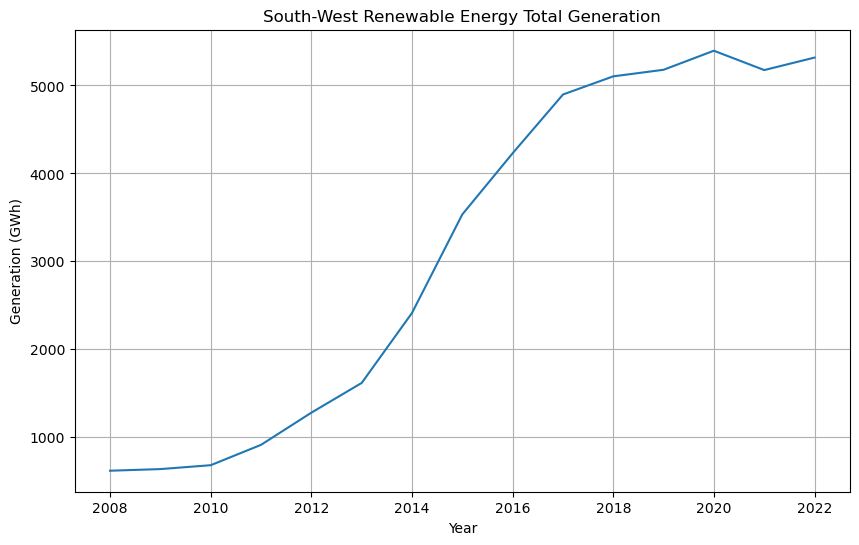

In [502]:
# Plot to check the data
plt.figure(figsize=(10, 6))
plt.plot(data_generation, label='South-West Renewable Energy Generation')
plt.title('South-West Renewable Energy Total Generation')
plt.xlabel('Year')
plt.ylabel('Generation (GWh)')
plt.grid(True)
plt.show()

In [504]:
# Automatically find the best ARIMA parameters
generation_model = pm.auto_arima(data_generation, start_p=0, start_q=0,
                                 max_p=5, max_q=5, m=1,
                                 start_P=0, seasonal=False,
                                 d=1, D=1, trace=True,
                                 error_action='ignore',  
                                 suppress_warnings=True, 
                                 stepwise=True)

print(generation_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=207.700, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=202.327, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=214.849, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=204.220, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=204.268, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=201.569, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=203.536, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=203.546, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=205.500, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.334 seconds
                               SARIMAX Results                                
Dep. Variable:                   

In [506]:
# Fit the ARIMA model on the entire dataset
model_fit = auto_arima(data_generation['Total'], seasonal=True, m=1) 

In [508]:
# Forecast future values for the next 8 years
forecast_steps = 8
forecast, conf_int = model_fit.predict(n_periods=forecast_steps, return_conf_int=True)

data_freq = pd.infer_freq(data_capacity.index)
forecast_index = pd.date_range(start=data_capacity.index[-1], periods=forecast_steps + 1, freq=data_freq)[1:]

# Convert forecast and confidence intervals to pandas Series/DataFrame
forecast_series = pd.Series(forecast, index=forecast_index)
conf_int_df = pd.DataFrame(conf_int, index=forecast_index, columns=['Lower Bound', 'Upper Bound'])


In [510]:
print(forecast)

2023-01-01    5428.777833
2024-01-01    5517.207294
2025-01-01    5586.993187
2026-01-01    5642.066132
2027-01-01    5685.528058
2028-01-01    5719.826913
2029-01-01    5746.894547
2030-01-01    5768.255517
Freq: AS-JAN, dtype: float64


In [512]:
print (forecast_series)

2023-01-01    5428.777833
2024-01-01    5517.207294
2025-01-01    5586.993187
2026-01-01    5642.066132
2027-01-01    5685.528058
2028-01-01    5719.826913
2029-01-01    5746.894547
2030-01-01    5768.255517
Freq: AS-JAN, dtype: float64


In [514]:
# Evaluation metrics for the model
y_pred = model_fit.predict_in_sample()
mse = mean_squared_error(data_generation['Total'], y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(data_capacity['Total'], y_pred)
r2 = r2_score(data_capacity['Total'], y_pred)

print(f"Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Evaluation Metrics:
Mean Squared Error (MSE): 94867.85
Root Mean Squared Error (RMSE): 308.01
Mean Absolute Error (MAE): 691.49
R-squared (R2): 0.73


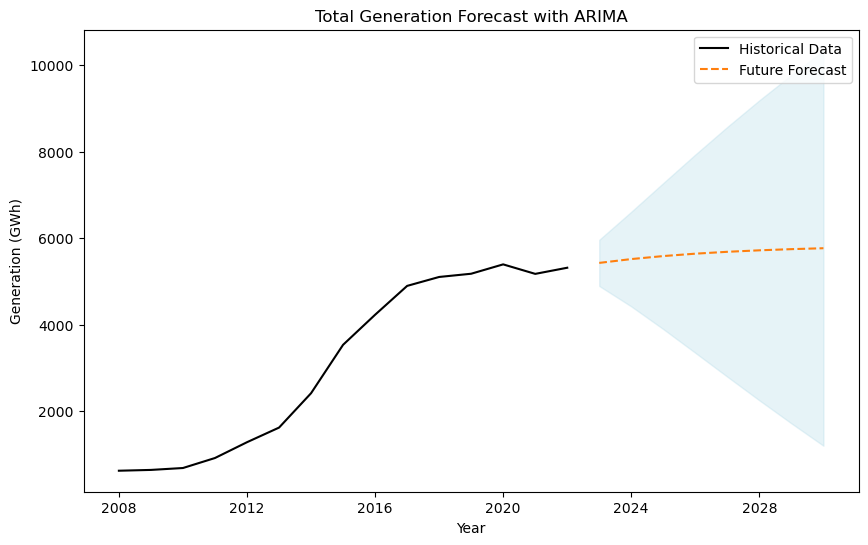

In [516]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(data_generation.index, data_generation['Total'], label='Historical Data', color='black')
plt.plot(forecast_series.index, forecast_series, label='Future Forecast', color='tab:orange', linestyle='--')
plt.fill_between(conf_int_df.index, conf_int_df['Lower Bound'], conf_int_df['Upper Bound'], color='lightblue', alpha=0.3)

plt.title('Total Generation Forecast with ARIMA')
plt.xlabel('Year')
plt.ylabel('Generation (GWh)')
plt.legend()
plt.show()

In [518]:
data_generation

,Total
Year,
2008-01-01,619.932945
2009-01-01,638.576196
2010-01-01,682.689455
2011-01-01,914.037340
2012-01-01,1279.483877
2013-01-01,1618.069851
2014-01-01,2413.391705
2015-01-01,3533.108366
2016-01-01,4228.097744


# Prophet

In [521]:
# Prepare the data for Prophet
data_prophet = data_generation.reset_index().rename(columns={'Year': 'ds', 'Total': 'y'})

In [523]:
# Initialise the Prophet model with default parameters
model = Prophet()

# Fit the model
model.fit(data_prophet)

08:02:33 - cmdstanpy - INFO - Chain [1] start processing
08:02:33 - cmdstanpy - INFO - Chain [1] done processing


In [525]:
# Tuning parameters
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.1)
model.fit(data_prophet)


08:02:34 - cmdstanpy - INFO - Chain [1] start processing
08:02:34 - cmdstanpy - INFO - Chain [1] done processing


In [527]:
# Create a dataframe with future dates
future = model.make_future_dataframe(periods=9, freq='Y')  # 5 years into the future

# Make a forecast
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-01,120.762972,-605.301153,874.000089,120.762972,120.762972,14.201262,14.201262,14.201262,14.201262,14.201262,14.201262,0.0,0.0,0.0,134.964234
1,2009-01-01,552.402686,-152.855268,1190.873678,552.402686,552.402686,-20.818714,-20.818714,-20.818714,-20.818714,-20.818714,-20.818714,0.0,0.0,0.0,531.583972
2,2010-01-01,982.863055,257.992277,1633.376431,982.863055,982.863055,-9.151951,-9.151951,-9.151951,-9.151951,-9.151951,-9.151951,0.0,0.0,0.0,973.711104
3,2011-01-01,1413.323425,769.152913,2077.218205,1413.323425,1413.323425,2.526110,2.526110,2.526110,2.526110,2.526110,2.526110,0.0,0.0,0.0,1415.849535
4,2012-01-01,1843.783795,1165.781136,2569.363147,1843.783795,1843.783795,14.201262,14.201262,14.201262,14.201262,14.201262,14.201262,0.0,0.0,0.0,1857.985056
5,2013-01-01,2275.423508,1555.215583,2992.447915,2275.423508,2275.423508,-20.818714,-20.818714,-20.818714,-20.818714,-20.818714,-20.818714,0.0,0.0,0.0,2254.604794
6,2014-01-01,2705.883877,1957.351906,3390.963115,2705.883877,2705.883877,-9.151951,-9.151951,-9.151951,-9.151951,-9.151951,-9.151951,0.0,0.0,0.0,2696.731926
7,2015-01-01,3136.344247,2518.592862,3864.946484,3136.344247,3136.344247,2.526110,2.526110,2.526110,2.526110,2.526110,2.526110,0.0,0.0,0.0,3138.870357
8,2016-01-01,3566.804616,2904.954285,4217.516182,3566.804616,3566.804616,14.201262,14.201262,14.201262,14.201262,14.201262,14.201262,0.0,0.0,0.0,3581.005878
9,2017-01-01,3998.444309,3339.397601,4632.476614,3998.444309,3998.444309,-20.818714,-20.818714,-20.818714,-20.818714,-20.818714,-20.818714,0.0,0.0,0.0,3977.625595


In [529]:
# Cross-validation for evaluation
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

print(df_p[['rmse', 'mse', 'mae', 'mape', 'coverage']])


  0%|          | 0/23 [00:00<?, ?it/s]

08:02:37 - cmdstanpy - INFO - Chain [1] start processing
08:02:44 - cmdstanpy - INFO - Chain [1] done processing
08:02:44 - cmdstanpy - INFO - Chain [1] start processing
08:02:50 - cmdstanpy - INFO - Chain [1] done processing
08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1] done processing
08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1] done processing
08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1] done processing
08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1] done processing
08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1] done processing
08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1] done processing
08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1]

           rmse           mse          mae      mape  coverage
0    266.932862  7.125315e+04   257.512256  0.230515       0.0
1    325.760267  1.061198e+05   325.753831  0.228128       0.0
2    572.719934  3.280081e+05   533.077571  0.253847       0.0
3   1017.741614  1.035798e+06   987.740019  0.328315       0.0
4   1132.201464  1.281880e+06  1127.249012  0.295292       0.0
5    952.526898  9.073075e+05   949.829200  0.210464       0.0
6    648.642899  4.207376e+05   571.624148  0.115637       0.5
7    264.083400  6.974004e+04   264.081599  0.051375       1.0
8    385.667536  1.487394e+05   370.432799  0.069687       1.0
9    812.320568  6.598647e+05   761.248180  0.145227       0.5
10   750.509104  5.632639e+05   615.979962  0.203361       0.0
11   266.932862  7.125315e+04   257.512256  0.230515       0.0
12   325.760267  1.061198e+05   325.753831  0.228128       0.0
13   572.719934  3.280081e+05   533.077571  0.253847       0.0
14  1017.741614  1.035798e+06   987.740019  0.328315   

In [530]:
# Evaluation Metrics
y_true = data_prophet['y']
y_pred = forecast.loc[:len(y_true)-1, 'yhat']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Evaluation Metrics:
Mean Squared Error (MSE): 290381.00
Root Mean Squared Error (RMSE): 538.87
Mean Absolute Error (MAE): 485.70
R-squared (R2): 0.92


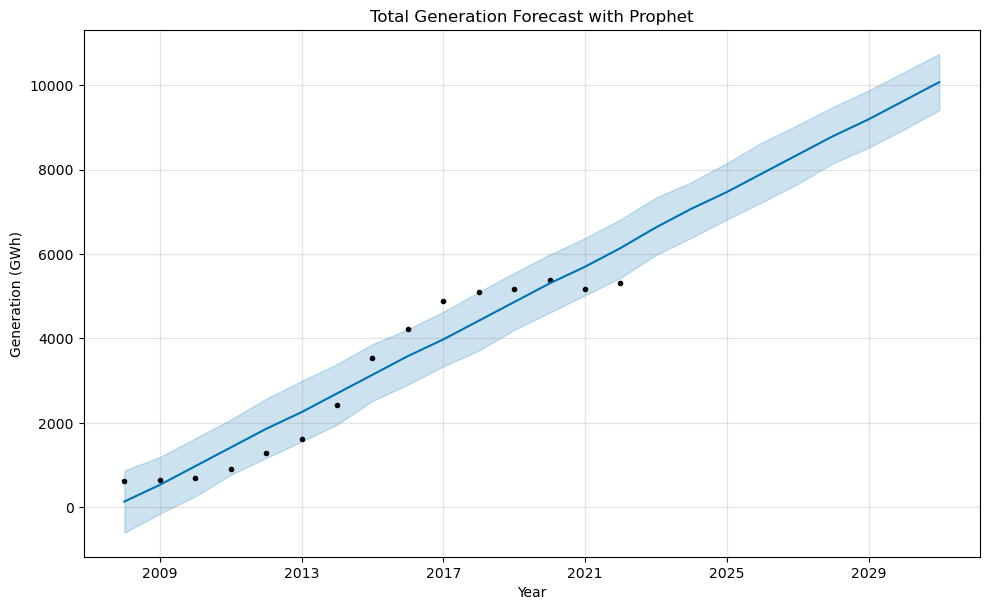

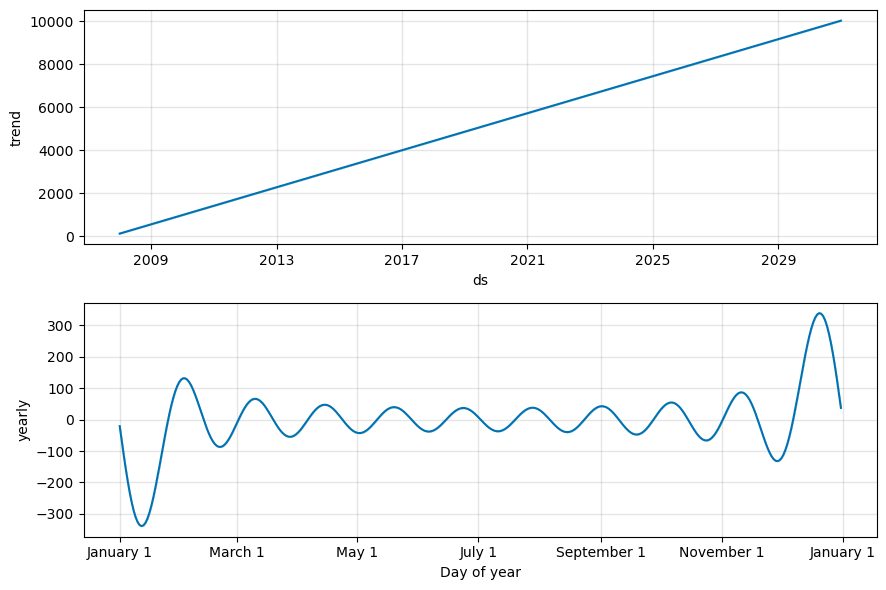

In [533]:
# Plot the forecast
model.plot(forecast)
plt.title('Total Generation Forecast with Prophet')
plt.xlabel('Year')
plt.ylabel('Generation (GWh)')
plt.show()

# Plot forecast components
model.plot_components(forecast)
plt.show()


# Plotting all 3 estimates

In [536]:
# Historical Data
historical_years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
historical_gwh = [619.93, 638.58, 682.69, 914.04, 1279.48, 1618.07, 2413.39, 3533.11, 4228.10, 4896.10, 5103.42, 5177.96, 5394.65, 5174.73, 5316.72]

# ARIMA Data Forecast
arima_forecast_years = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]
arima_forecast_gwh = [5428.78, 5517.21, 5586.99, 5642.07, 5685.53, 5719.82, 5746.89, 5768.26]

#Prophet Data Forecast
prophet_forecast_years = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]
prophet_forecast_gwh = [6580.53, 7010.83, 7442.31, 7872.61, 8302.91, 8733.22, 9164.70, 9595.00]



# TPlanning Data Forecast
planning_forecast_dates = ['01/04/2024', '26/12/2024', '07/07/2026']
planning_forecast_gwh = [5295.75, 5868.86, 10936.04]



In [538]:
# Convert planning data to datetime
planning_forecast_years = pd.to_datetime(planning_forecast_dates).year

/var/folders/2w/hpz23rfj7l32vsh540rqdd_80000gn/T/ipykernel_95765/123807126.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  planning_forecast_years = pd.to_datetime(planning_forecast_dates).year


In [540]:
# Align all data 
forecast_df = pd.DataFrame({
    'Year': prophet_forecast_years,
    'Prophet': prophet_forecast_gwh,
    'ARIMA': arima_forecast_gwh
})

planning_forecast_data = pd.DataFrame({
    'Year': planning_forecast_years,
    'Planning Data': planning_forecast_gwh
})

# Merge the dataframes on 'Year'
forecast_df = forecast_df.merge(planning_forecast_data, on='Year', how='left')

In [542]:
forecast_df

,Year,Prophet,ARIMA,Planning Data
0,2023,6580.53,5428.78,NaN
1,2024,7010.83,5517.21,5295.75
2,2024,7010.83,5517.21,5868.86
3,2025,7442.31,5586.99,NaN
4,2026,7872.61,5642.07,10936.04
5,2027,8302.91,5685.53,NaN
6,2028,8733.22,5719.82,NaN
7,2029,9164.70,5746.89,NaN
8,2030,9595.00,5768.26,NaN


In [544]:
# Calculate the average forecast across available forecasts for each year
forecast_df['Average'] = forecast_df[['Prophet', 'ARIMA', 'Planning Data']].mean(axis=1)

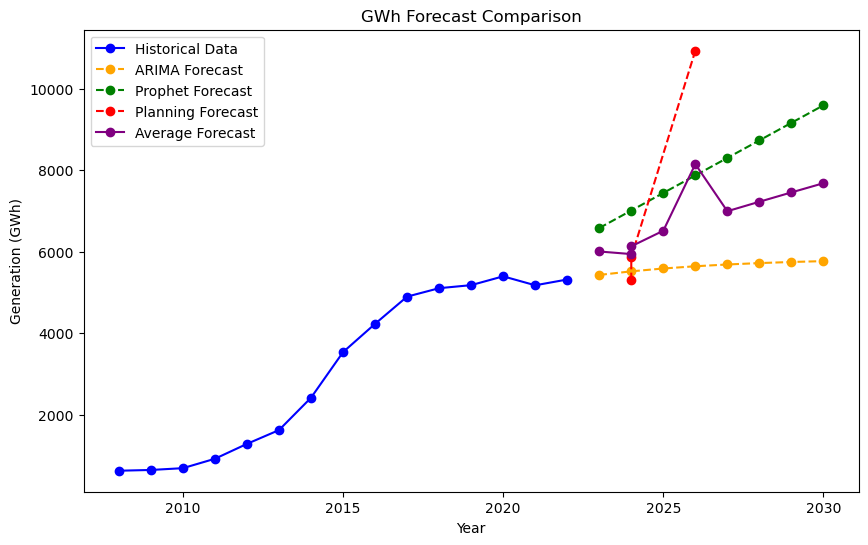

In [546]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot historical and forecast data
plt.plot(historical_years, historical_gwh, label='Historical Data', color='blue', marker='o')
plt.plot(arima_forecast_years, arima_forecast_gwh, label='ARIMA Forecast', color='orange', linestyle='--', marker='o')
plt.plot(prophet_forecast_years, prophet_forecast_gwh, label='Prophet Forecast', color='green', linestyle='--', marker='o')
plt.plot(planning_forecast_years, planning_forecast_gwh, label='Planning Forecast', color='red', linestyle='--', marker='o')
plt.plot(forecast_df['Year'], forecast_df['Average'], label='Average Forecast', color='purple', linestyle='-', marker='o')
plt.title('GWh Forecast Comparison')
plt.xlabel('Year')
plt.ylabel('Generation (GWh)')
plt.legend()

# Display the plot
plt.show()

In [548]:
# Convert average forecast from GWh to TWh
forecast_df['Average_TWh'] = forecast_df['Average'] / 1000
forecast_df['ARIMA_TWh'] = forecast_df['ARIMA'] / 1000
forecast_df['Planning_TWh'] = forecast_df['Planning Data'] / 1000

data_generation = data_generation.copy()
data_generation['historical_TWh'] = data_generation['Total'] / 1000

In [550]:
# Regression coefficients
intercept = 623.5313
slope = -2.2624


# Predict carbon dioxide emissions using the regression model
forecast_df['Average_Predicted_CO2_Emissions'] = intercept + slope * forecast_df['Average_TWh']
forecast_df['Min_Predicted_CO2_Emissions'] = intercept + slope * forecast_df['Planning_TWh']
forecast_df['Max_Predicted_CO2_Emissions'] = intercept + slope * forecast_df['ARIMA_TWh']
data_generation['Historical_CO2_Emissions'] = intercept + slope * data_generation['historical_TWh']

# Ensure the column names are correct
print(forecast_df[['Year', 'Average_Predicted_CO2_Emissions', 'Min_Predicted_CO2_Emissions', 'Max_Predicted_CO2_Emissions', ]])

   Year  Average_Predicted_CO2_Emissions  Min_Predicted_CO2_Emissions  \
0  2023                       609.946369                          NaN   
1  2024                       610.089786                   611.550195   
2  2024                       609.657584                   610.253591   
3  2025                       608.792556                          NaN   
4  2026                       605.092197                   598.789603   
5  2027                       607.707577                          NaN   
6  2028                       607.182021                          NaN   
7  2029                       606.663309                          NaN   
8  2030                       606.152380                          NaN   

   Max_Predicted_CO2_Emissions  
0                   611.249228  
1                   611.049164  
2                   611.049164  
3                   610.891294  
4                   610.766681  
5                   610.668357  
6                   610.590779  
7    

In [552]:
# Ensure 'Year' is correctly formatted as datetime
if 'Year' in data_generation.columns:
    data_generation['Year'] = pd.to_datetime(data_generation['Year']).dt.year

if 'Year' in forecast_df.columns:
    forecast_df['Year'] = pd.to_datetime(forecast_df['Year']).dt.year

# Reset index if 'Year' is also an index
if 'Year' in data_generation.index.names:
    data_generation = data_generation.reset_index()

if 'Year' in forecast_df.index.names:
    forecast_df = forecast_df.reset_index()

# Convert the 'Year' column to datetime format if not already
forecast_df['Year'] = pd.to_datetime(forecast_df['Year'], format='%Y')
data_generation['Year'] = pd.to_datetime(data_generation['Year'], format='%Y')

# Sort the DataFrames by Year
forecast_df = forecast_df.sort_values(by='Year')
data_generation = data_generation.sort_values(by='Year')

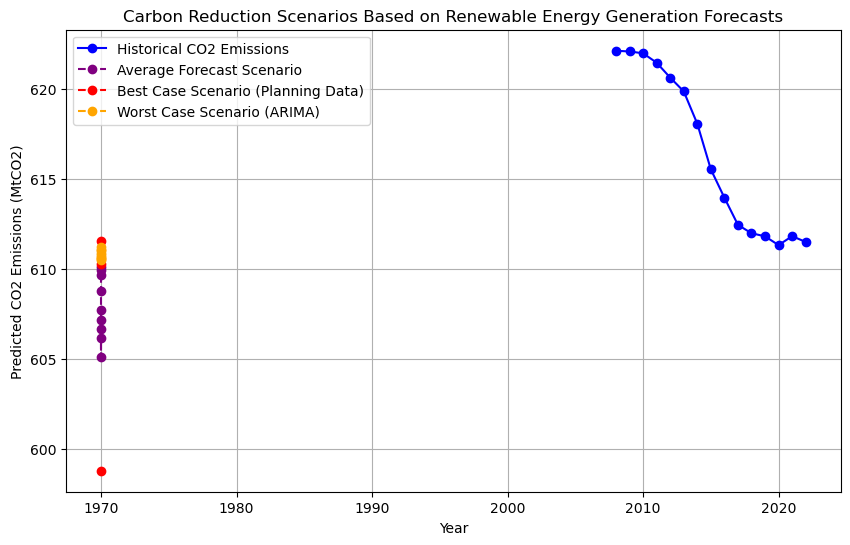

In [554]:
# Plotting the results
plt.figure(figsize=(10, 6))

plt.plot(data_generation['Year'], data_generation['Historical_CO2_Emissions'], label='Historical CO2 Emissions', color='blue', marker='o')
plt.plot(forecast_df['Year'], forecast_df['Average_Predicted_CO2_Emissions'], label='Average Forecast Scenario', color='purple', linestyle='--', marker='o')
plt.plot(forecast_df['Year'], forecast_df['Min_Predicted_CO2_Emissions'], label='Best Case Scenario (Planning Data)', color='red', linestyle='--', marker='o')
plt.plot(forecast_df['Year'], forecast_df['Max_Predicted_CO2_Emissions'], label='Worst Case Scenario (ARIMA)', color='orange', linestyle='--', marker='o')

plt.title('Carbon Reduction Scenarios Based on Renewable Energy Generation Forecasts')
plt.xlabel('Year')
plt.ylabel('Predicted CO2 Emissions (MtCO2)')
plt.legend()
plt.grid(True)
plt.show()
